# Problem Set #3
- MACS 30250, Dr. Evans 
- Name: Kento Yoshizawa (CNET: kyoshizawa) 
- Date: May 20, 2020

In [1]:
import numpy as np
import scipy.optimize as opt
import scipy.interpolate as intpl

## 1. Stochastic i.i.d. cake eating problem
### (a)

In [2]:
eps_vec = np.array([-1.40, -0.55, 0.0, 0.55, 1.4])
eps_prob = np.array([0.1, 0.2, 0.4, 0.2, 0.1])
eps_size = eps_vec.shape[0]

W_vec = np.linspace(0.1, 10, 30)
W_size = W_vec.shape[0]

In [3]:
def util(W, W_pr, gamma):
    return ((W - W_pr) ** (1 - gamma) - 1) / (1 - gamma)

In [4]:
def neg_V_iid(W_pr, *args):
    W, eps, util, Exp_V_t_interp, gamma, beta = args
    Vtp1 = np.exp(eps) * util(W, W_pr, gamma) + beta * Exp_V_t_interp(W_pr)
    neg_Vtp1 = -Vtp1
    
    return neg_Vtp1

In [5]:
%%time
beta  = 0.9
gamma = 2.2

V_init = np.zeros((W_size, eps_size))
V_new = V_init.copy()

VF_iter = 0
VF_dist = 10
VF_maxiter = 200
VF_mindist = 1e-8

while (VF_iter < VF_maxiter) & (VF_dist > VF_mindist):
    VF_iter += 1
    V_init = V_new.copy()
    V_new = np.zeros((W_size, eps_size))
    psi_mat = np.zeros((W_size, eps_size))
    
    # Integrate out eps_pr from V_init
    Exp_V = V_init @ eps_prob.reshape((eps_size, 1))
    
    # Interpolate expected value function
    Exp_V_interp = intpl.interp1d(W_vec, Exp_V.flatten(), kind='cubic',
                                   fill_value='extrapolate')

    for eps_ind in range(eps_size):
        for W_ind in range(W_size):
            W = W_vec[W_ind]
            eps = eps_vec[eps_ind]
            V_args = (W, eps, util, Exp_V_interp, gamma, beta)
            results1 = opt.minimize_scalar(neg_V_iid, bounds=(1e-10, W - 1e-10),
                                           args=V_args, method='bounded')
            V_new[W_ind, eps_ind] = -results1.fun
            psi_mat[W_ind, eps_ind] = results1.x
    VF_dist = ((V_init - V_new) ** 2).sum()
    if (VF_iter == 1) | (VF_iter%10 == 0):
        print(f'VF_iter: {VF_iter:0>3} | VF_dist: {VF_dist}')
        
print(f'VF_iter: {VF_iter:0>3} | VF_dist: {VF_dist} | Done')
V_1   = V_new.copy()
psi_1 = psi_mat.copy()

VF_iter: 001 | VF_dist: 3494.416552492849
VF_iter: 010 | VF_dist: 5436.089591828782
VF_iter: 020 | VF_dist: 1932.1399178953084
VF_iter: 030 | VF_dist: 436.4919599690147
VF_iter: 040 | VF_dist: 76.57766324533219
VF_iter: 050 | VF_dist: 10.561431496159805
VF_iter: 060 | VF_dist: 1.1970454632782899
VF_iter: 070 | VF_dist: 0.13256302627395244
VF_iter: 080 | VF_dist: 0.015917236304939762
VF_iter: 090 | VF_dist: 0.0019858699368969146
VF_iter: 100 | VF_dist: 0.0002447274935591932
VF_iter: 110 | VF_dist: 2.9648381689848484e-05
VF_iter: 120 | VF_dist: 3.5833367786959895e-06
VF_iter: 130 | VF_dist: 4.352039714144155e-07
VF_iter: 140 | VF_dist: 5.2994925146231495e-08
VF_iter: 148 | VF_dist: 9.828523765807006e-09 | Done
CPU times: user 23.6 s, sys: 482 ms, total: 24.1 s
Wall time: 24.4 s


### (b)

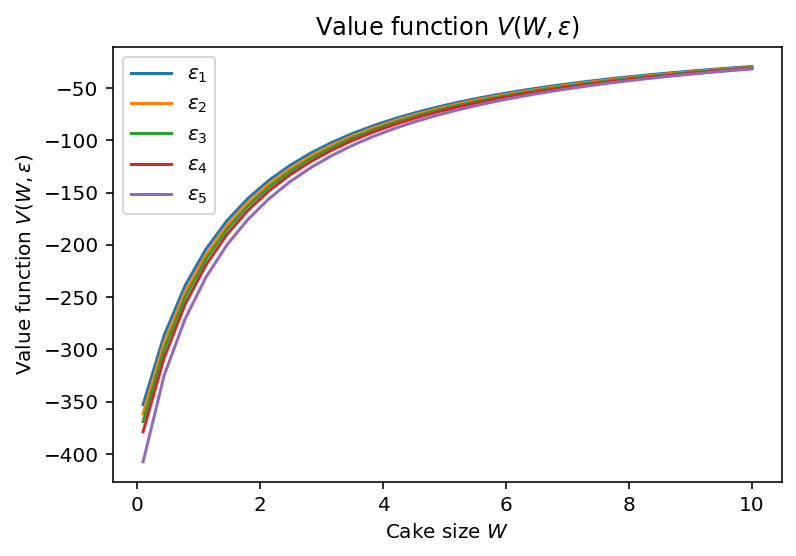

In [6]:
import matplotlib.pyplot as plt
plt.plot(W_vec, V_1[:, 0], label='$\epsilon_1$')
plt.plot(W_vec, V_1[:, 1], label='$\epsilon_2$')
plt.plot(W_vec, V_1[:, 2], label='$\epsilon_3$')
plt.plot(W_vec, V_1[:, 3], label='$\epsilon_4$')
plt.plot(W_vec, V_1[:, 4], label='$\epsilon_5$')
plt.title('Value function $V(W,\epsilon)$')
plt.xlabel('Cake size $W$')
plt.ylabel('Value function $V(W,\epsilon)$')
plt.legend();

### (c)

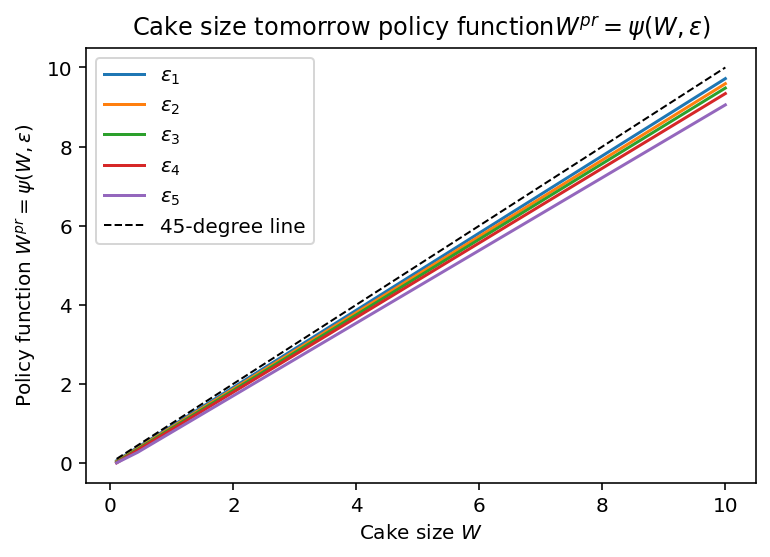

In [7]:
plt.plot(W_vec, psi_1[:, 0], label='$\epsilon_1$')
plt.plot(W_vec, psi_1[:, 1], label='$\epsilon_2$')
plt.plot(W_vec, psi_1[:, 2], label='$\epsilon_3$')
plt.plot(W_vec, psi_1[:, 3], label='$\epsilon_4$')
plt.plot(W_vec, psi_1[:, 4], label='$\epsilon_5$')
plt.plot(W_vec, W_vec, color='black', linewidth=1, linestyle='--',
         label='45-degree line')
plt.title('Cake size tomorrow policy function' +
          '$W^{pr}=\psi(W,\epsilon)$')
plt.xlabel('Cake size $W$')
plt.ylabel('Policy function $W^{pr}=\psi(W,\epsilon)$')
plt.legend();

## 2. Persistent AR(1) stochastic cake eating problem
### (a)

In [8]:
trans_mat = np.array([[0.40, 0.28, 0.18, 0.10, 0.04],
                      [0.20, 0.40, 0.20, 0.13, 0.07],
                      [0.10, 0.20, 0.40, 0.20, 0.10],
                      [0.07, 0.13, 0.20, 0.40, 0.20],
                      [0.04, 0.10, 0.18, 0.28, 0.40]])

In [9]:
%%time
beta  = 0.9
gamma = 2.2

V_init = np.zeros((W_size, eps_size))
V_new = V_init.copy()

VF_iter = 0
VF_dist = 10
VF_maxiter = 200
VF_mindist = 1e-8

while (VF_iter < VF_maxiter) & (VF_dist > VF_mindist):
    VF_iter += 1
    V_init = V_new.copy()
    V_new = np.zeros((W_size, eps_size))
    psi_mat = np.zeros((W_size, eps_size))
    
    for eps_ind in range(eps_size):
        # Calculate expected value, integrate out epsilon prime
        trans_mat_ind = trans_mat[eps_ind, :]
        Exp_V = V_init @ trans_mat_ind.reshape((eps_size, 1))
        
        # Interpolate expected value function
        Exp_V_interp = intpl.interp1d(W_vec, Exp_V.flatten(), kind='cubic',
                                      fill_value='extrapolate')
        for W_ind in range(W_size):
            W = W_vec[W_ind]
            eps = eps_vec[eps_ind]
            V_args = (W, eps, util, Exp_V_interp, gamma, beta)
            results1 = opt.minimize_scalar(neg_V_iid, bounds=(1e-10, W - 1e-10),
                                           args=V_args, method='bounded')
            V_new[W_ind, eps_ind] = -results1.fun
            psi_mat[W_ind, eps_ind] = results1.x
    
    VF_dist = ((V_init - V_new) ** 2).sum()
    if (VF_iter == 1) | (VF_iter%10 == 0):
        print(f'VF_iter: {VF_iter:0>3} | VF_dist: {VF_dist}')

print(f'VF_iter: {VF_iter:0>3} | VF_dist: {VF_dist} | Done')

V_2 = V_new.copy()
psi_2 = psi_mat.copy()

VF_iter: 001 | VF_dist: 3494.416552492849
VF_iter: 010 | VF_dist: 6169.1406209651595
VF_iter: 020 | VF_dist: 2160.226185380101
VF_iter: 030 | VF_dist: 491.6940988700444
VF_iter: 040 | VF_dist: 87.8117204617702
VF_iter: 050 | VF_dist: 12.622804626472998
VF_iter: 060 | VF_dist: 1.5198717034268405
VF_iter: 070 | VF_dist: 0.17220051197775668
VF_iter: 080 | VF_dist: 0.020170097655880306
VF_iter: 090 | VF_dist: 0.0024566765881965207
VF_iter: 100 | VF_dist: 0.0003022107274658296
VF_iter: 110 | VF_dist: 3.69457525058525e-05
VF_iter: 120 | VF_dist: 4.4889815518059275e-06
VF_iter: 130 | VF_dist: 5.446819407267424e-07
VF_iter: 140 | VF_dist: 6.616508782305053e-08
VF_iter: 149 | VF_dist: 9.932175050620474e-09 | Done
CPU times: user 23.2 s, sys: 637 ms, total: 23.8 s
Wall time: 23.8 s


### (b)

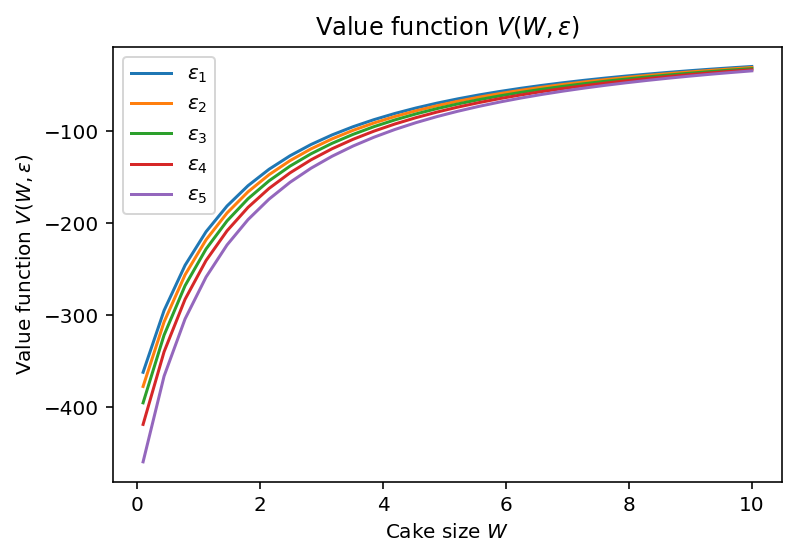

In [10]:
plt.plot(W_vec, V_2[:, 0], label='$\epsilon_1$')
plt.plot(W_vec, V_2[:, 1], label='$\epsilon_2$')
plt.plot(W_vec, V_2[:, 2], label='$\epsilon_3$')
plt.plot(W_vec, V_2[:, 3], label='$\epsilon_4$')
plt.plot(W_vec, V_2[:, 4], label='$\epsilon_5$')
plt.title('Value function $V(W,\epsilon)$')
plt.xlabel('Cake size $W$')
plt.ylabel('Value function $V(W,\epsilon)$')
plt.legend();

### (c)

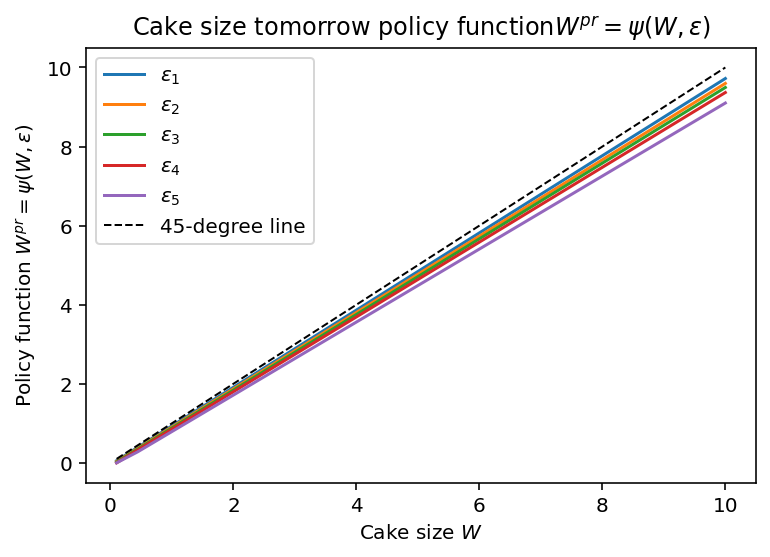

In [11]:
plt.plot(W_vec, psi_2[:, 0], label='$\epsilon_1$')
plt.plot(W_vec, psi_2[:, 1], label='$\epsilon_2$')
plt.plot(W_vec, psi_2[:, 2], label='$\epsilon_3$')
plt.plot(W_vec, psi_2[:, 3], label='$\epsilon_4$')
plt.plot(W_vec, psi_2[:, 4], label='$\epsilon_5$')
plt.plot(W_vec, W_vec, color='black', linewidth=1, linestyle='--',
         label='45-degree line')
plt.title('Cake size tomorrow policy function' +
          '$W^{pr}=\psi(W,\epsilon)$')
plt.xlabel('Cake size $W$')
plt.ylabel('Policy function $W^{pr}=\psi(W,\epsilon)$')
plt.legend();